In [1]:
# read in the weekly climotrend data and interpolate to daily

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics
import dask

In [2]:
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler

In [7]:
start_year = 1990
# Parameters
today_date = datetime.datetime.now()
pred_year = today_date.year + 1

E = ed.EsioData.load()
mod_dir = E.model_dir
cmod = 'climatology'
runType = 'forecast'

<xarray.Dataset>
Dimensions:    (pdim: 3, time: 1, x: 304, y: 448)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    xm         (x) int64 dask.array<shape=(304,), chunksize=(304,)>
    ym         (y) int64 dask.array<shape=(448,), chunksize=(448,)>
  * pdim       (pdim) int64 0 1 2
    week       int64 ...
  * time       (time) datetime64[ns] 2020-05-05
Data variables:
    fitparams  (time, y, x, pdim) float64 dask.array<shape=(1, 448, 304, 3), chunksize=(1, 448, 304, 3)>


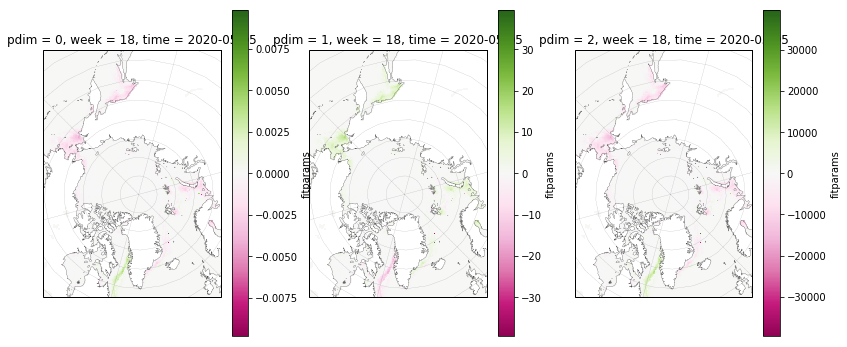

In [8]:
# read in the fit parameters for a random time and 
test_year = 2020
cweek = 18

file_in = os.path.join(mod_dir, cmod, runType, 'param_weekly', 
                        str(test_year)+'_week'+format(cweek, '02')+'_'+str(start_year)+'_'+str(test_year - 1)+'_SICfitparams.nc')

ds = xr.open_mfdataset(file_in, autoclose=True, parallel=True)
print(ds)

# plot one time at random to ensure it is about right Nplots has to be one more than you'd think
(f, axes) = ice_plot.multi_polar_axis(ncols=3, nrows=1, Nplots = 4, sizefcter=3)
for count in np.arange(0,3,1):
    tmp=ds.fitparams.isel(pdim=count,time=0)
    tmp.plot.pcolormesh(cmap='PiYG',ax=axes[count], x='lon', y='lat',transform=ccrs.PlateCarree())
    
# the last parameter is large except where sic is one so there is a lot of compensation 
# among the terms in the reconstruction
# This means it is a very bad idea to interpolate the fit param
# instead must use fit params to extrapolate a weekly value and then interpolate weekly to daily

In [9]:
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly_byweek/*byweek.nc', concat_dim='time', autoclose=True, parallel=True).sic
#ds_51 = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'_yearly_byweek/*byweek.nc', concat_dim='time', autoclose=True, parallel=True)
ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly_byweek/*byweek.nc', concat_dim='time', autoclose=True, parallel=True).sic

ds_79=ds_79.sel(time=slice(str(start_year),'2050'))  # end year just has to be way in the future
ds_81=ds_81.sel(time=slice('2015',str(pred_year-1)))  # restrict to before prediciton year, lower year not important

# Combine bootstrap with NASA NRT
da_sic = ds_79.combine_first(ds_81)  # takes ds_79 as priority

year_all = [x.year for x in pd.to_datetime(da_sic.time.values)]
da_sic.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':da_sic.time})

# put week coordinate back since combine first rubbed them out
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(da_sic.time.values)]
weeks= np.ceil(np.divide(DOY,7))
weeks = weeks.astype(int)
da_sic.coords['week'] = xr.DataArray(weeks, dims='time', coords={'time':da_sic.time})

In [10]:
# read in the weekly climo trend daily and resample to daily
# /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc_weekly/*SIC.nc
# resample whole year of pred_year, it is quick
da_weekly = None
# read in the fit parameters for this range of years
files_in = os.path.join(mod_dir, cmod, runType, 'sipn_nc_weekly','*_SIC.nc')

# time is end of period, so shift to middle
da_weekly = xr.open_mfdataset(files_in, concat_dim='time', autoclose=True, parallel=True).ClimoTrendSIC
da_weekly['time'] = da_weekly.time.values - np.timedelta64(3,'D') # shift to midpoint of interval for interpolation
UpdateAll = False   # if False then only make prediction for next year, past years done already
if ~UpdateAll:
    # limit to recent year
    today_date = datetime.datetime.now()
    pred_year = today_date.year + 1  # we are predicting the next since have done this year already
    da_weekly=da_weekly.sel(time=slice(str(pred_year-1),'2030'))  # but need data from this year too to ensure 
                        # that we have at least one time in the year before we want to predict for interpolating
da_weekly

<xarray.DataArray 'ClimoTrendSIC' (time: 71, y: 448, x: 304)>
dask.array<shape=(71, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    week     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 10 11 12 13 14 15 16 17 18 19
  * time     (time) datetime64[ns] 2019-01-04 2019-01-11 ... 2020-05-09

In [11]:
# interpolate to daily
da_weekly.load()
da_daily = da_weekly.resample(time='1D').interpolate('linear')
#da_daily = da_weekly.resample(time='1D').interpolate('cubic')  # not working made all zeros
da_daily=da_daily.sel(time=slice('2018','2030'))
#print(da_daily.time.values)

ocnmask = da_weekly.isel(time=3).notnull()  
ocnmask.name = 'oceanmask'

da_daily=da_daily.where(da_daily>0,other=0).where(ocnmask)
da_daily=da_daily.where(da_daily<1,other=1).where(ocnmask)

# add doy and clean up
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(da_daily.time.values)]
da_daily.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':da_daily.time})
da_daily.name = 'sic'
da_daily = da_daily.drop('week')
da_daily

<xarray.DataArray 'sic' (time: 492, y: 448, x: 304)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.74

In [13]:
# Save to disk
start_year = 1990
maxdays=len(da_daily.time)+1
for cday in np.arange(1,maxdays,1):

    
    today = da_daily.isel(time=cday-1)
    today = today.expand_dims('time')
    pred_year = today['time.year'][0].values

    file_out = os.path.join(mod_dir, cmod, runType, 'sipn_nc', 
                        str(pred_year)+'_'+format(today.doy.values, '03')+'_'+str(start_year)+'_'+str(pred_year - 1)+'_SIC.nc')

    if ((os.path.isfile(file_out)) & (cday<maxdays-17)): # force redo last few weeks each time, it is fast
#        print(file_out,' has already been done')
        continue

    today.to_netcdf(file_out)
    print("Saved",file_out)
    

Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_114_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_115_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_116_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_117_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_118_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_119_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_120_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_121_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_122_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2020_123_1990_2019_SIC.nc
Saved /home/disk/sipn/nicway/data/model/climatolog

<xarray.DataArray 'time' ()>
array('2018-01-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-01-04
    doy      int64 4
<xarray.DataArray 'time' ()>
array('2018-01-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    week     int64 1
    time     datetime64[ns] 2018-01-04


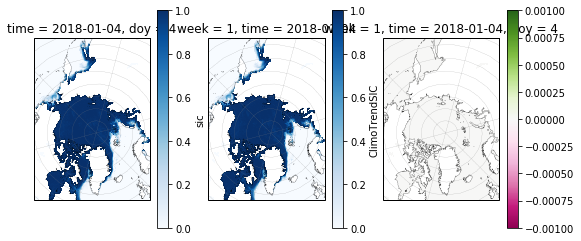

In [136]:
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=1,sizefcter=2)
fld1=da_daily.isel(time=3)
fld2=da_weekly.isel(time=1)
fld3=fld2-fld1  #flds at same time are identical so seems right
print(fld1.time)
print(fld2.time)

fld1.plot.pcolormesh(cmap='Blues',ax=axes[0], x='lon', y='lat',transform=ccrs.PlateCarree())
#axes[0].set_title('Week 1 Fit', fontsize=20)
fld2.plot.pcolormesh(cmap='Blues',ax=axes[1], x='lon', y='lat',transform=ccrs.PlateCarree())
#axes[1].set_title('Past Mean', fontsize=20)
fld3.plot.pcolormesh(cmap='PiYG',ax=axes[2], x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=-0.001,vmax=0.001)
